# Cellular Automata and Computation

In this workbook I investigate cellular automata visually and using machine learning. In our case cellular automata (CA) will be an array of 'cells' which take some value. The states of the cells will evolve in time based on their neighbors. CA evolution is often greatly simplified by restricting update rules to interactions between nearest or next-to-nearest neighbors.

One obvious problem to investigate is the degree to which the function of a cellular automaton can be modelled using machine learning methods. In the first part I'll begin by generating some cellular automata for viewing.

In [1]:
import numpy as np
import matplotlib.pyplot as pp
%matplotlib inline
#import seaborn

## Cellular Automata Spacetime
A CA spacetime is a matrix with each column representing the evolution of a cell through time. The following function begins with a single array indicating the initial state of the CA universe and constructs the matrix one row at a time by evolving the matrix according to a ruleset.

In [395]:
def generate_spacetime(rule, alive = 15, ca_width=30, ca_duration = 30, initial_state=None):
    dead = ca_width-alive
    spacetime = []
    space = np.int64( np.hstack((np.ones(alive), np.zeros(dead))) )
     np.random.shuffle( space )

    spacetime.append( space )

    s0 = list(range(ca_width))
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]


    for time_step in xrange(ca_duration):
        values = 4*spacetime[time_step][sr1] + 2*spacetime[time_step][s0] + 1*spacetime[time_step][sl1]
        space = [] 
        for value in values:
            if (rule >> value) & 0x1:
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)


def generate_spacetime_NNN(rule, alive = 200, ca_width = 400, ca_duration = 400):
    dead = ca_width-alive
    spacetime = []
    space = np.int64( np.hstack((np.ones(alive), np.zeros(dead))) )
    np.random.shuffle( space )
    spacetime.append( space )
    s0 = list(range(ca_width))
    sl3 = s0[3:] + s0[:3]
    sl2 = s0[2:] + s0[:2]
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]
    sr2 = s0[-2:] + s0[:-2]
    sr3 = s0[-3:] + s0[:-3]

    for time_step in range(ca_duration):
        values = 64*spacetime[time_step][sr3] + 32*spacetime[time_step][sr2] + 16*spacetime[time_step][sr1] + 8*spacetime[time_step][s0] + 4*spacetime[time_step][sl1] + 2*spacetime[time_step][sl2] + spacetime[time_step][sl3]
        space = []
        for value in values:
            if ((np.uint64(rule[value//64]) << np.uint64(value % 64)) & 0x8000000000000000):
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)

In [396]:
from matplotlib.colors import ListedColormap

def show_spacetime(spacetime):
    # make a color map of fixed colors
    cmap = ListedColormap(['gold','black'])
    # tell imshow about color map so that only set colors are used
    img = pp.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)
    #pp.colorbar(img,cmap=cmap, ticks=[0,1])
    pp.show()

# Elementary CA examples
First we look at the simple case of CA update rules that only depend on nearest neighboring cells. These 'elementary cellular automata' were classified by Stephen Wolfram who found the 2^3 inputs to each cell meant that each ruleset could be numbered with an 8 digit binary number. This gives 256 different possible rules. The nearest neighbor spacetime generator above takes a number between 0 and 255 and returns a corresponding spacetime.

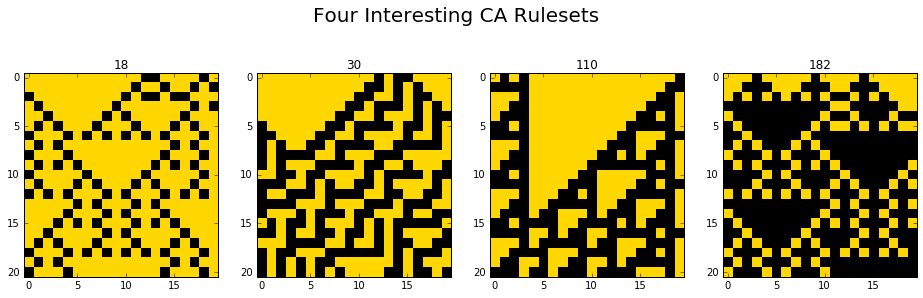

In [393]:

rules = [18, 30, 110, 182]
titles = [str(x) for x in rules]

from matplotlib.colors import ListedColormap
fig, subfigs = pp.subplots(1,4,figsize=(16, 5))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Four Interesting CA Rulesets', fontsize=20)

for i in range(4):
    ax = subfigs[i]
    ax.set_title(titles[i])
    spacetime = generate_spacetime(rules[i],alive = 3, ca_duration = 20, ca_width = 20)
    ax.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)


## Next-to-Nearest-Neighbor CA that solve a particular problem

Now let's look at three spacetimes for CA rulesets which have been found to perform the computational task of identifying whether the spacetime is mostly in the gold or black state.

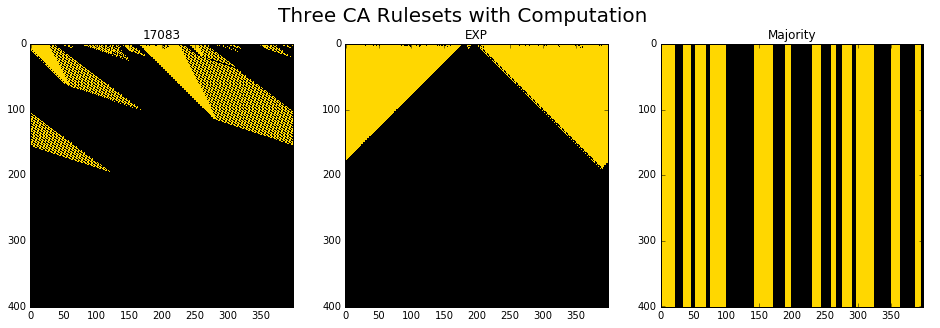

In [8]:
rule_17083 = [0x031001001fa00013, 0x331f9fff5975ffff]
rule_exp = [0x0505408305c90101, 0x200b0efb94c7cff7]
rule_majority = [0x0001011701171777, 0x01171777177f7fff]
rules = [rule_17083, rule_exp, rule_majority]
titles = ['17083', 'EXP', 'Majority']

from matplotlib.colors import ListedColormap
fig, subfigs = pp.subplots(1,3,figsize=(16, 5))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Three CA Rulesets with Computation', fontsize=20)

for i in range(3):
    ax = subfigs[i]
    ax.set_title(titles[i])
    spacetime = generate_spacetime_NNN(rules[i],alive = 200, ca_duration = 400, ca_width = 400)
    ax.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)


One interesting feature of 17083 and EXP is that local information is carried through the spacetime by 'particles' or propagating bits of information that can interact according to some ruleset. There is probably a deeper meaning in this, which we will not get into here.

# Machine Learning with CA

Cellular automata are archetypal patterns, so it's useful to see the qualitative ability for different neural networks to learn CA rulesets. 
If the neural network can reproduce the output of a CA ruleset (given its initial state), then it has inferred the underlying non-linear dynamics. We shall see that neural networks are challenged by such a task.

## Batch Generator
First, let's create a batch generator to dole out spacetime examples to our machine learning models.

In [486]:
def generate(rule, batch_size=10, ca_width=10, memory=0, min_dead=0):
    np.random.randint(ca_width+1)
    while True:
        data = generate_spacetime(rule=rule, 
                               alive = np.random.randint(ca_width+1-min_dead), 
                               ca_width=ca_width,
                               ca_duration = memory+1)
        samples = np.zeros((batch_size, memory+1, ca_width))
        targets = np.zeros((batch_size,1, ca_width))
        for i in range(batch_size):
            samples[i] = data[:-1]
            targets[i] = data[-1][0]
        yield samples, targets

In [106]:
# Testing out the generator
gen110 = generate(110, batch_size=3, memory=0)
next(gen110)

(array([[[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]],
 
        [[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]],
 
        [[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]]]),
 array([[ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.]]))

In [361]:
def test_predictions(model, generator):
    for i in range(10000):
        x,y = next(val_gen110)
        ypred = model.predict(x)
        if((1-y[0][0]).dot(np.around(ypred[0][0])) < 1):
            correct_predictions += 1
        
    print("%d/10000 correct predictions" % correct_predictions)
    
def precise_test(model, generator, tests):
    x,y = next(generator)
    correct_predictions = 0
    for i in range(tests):
        x,y = next(generator)
        ypred = model.predict(x)
        if(np.abs(np.sum(y - ypred)) < 1):
            correct_predictions += 1
        
    print(correct_predictions/np.float32(tests))

## Dense Network
For our first pass attempt, we'll try to train a single fully connected network layer to perform a timestep evolution on a small CA space. Because our output consists of mutually non-exclusive binary labels, we want to use a sigmoid activiation function with binary crossentropy loss.

In [488]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

train_gen110 = generate(110, batch_size=1, memory=0)
val_gen110 = generate(110, batch_size=1, memory=0)


model = Sequential() 
model.add(layers.Dense(10, activation='sigmoid',input_shape=(None, 10)))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**12,
                             epochs=8,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/8
4096/4096 [==============================] - 9s 2ms/step - loss: 0.6789 - val_loss: 0.6592
Epoch 2/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6385 - val_loss: 0.6339
Epoch 3/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6269 - val_loss: 0.6184
Epoch 4/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6173 - val_loss: 0.6408
Epoch 5/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6219 - val_loss: 0.6233
Epoch 6/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6188 - val_loss: 0.6020
Epoch 7/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6167 - val_loss: 0.6225
Epoch 8/8
4096/4096 [==============================] - 8s 2ms/step - loss: 0.6194 - val_loss: 0.6134


In [485]:
test_predictions(model, val_gen110)

117/1000 correct predictions


## Adding a hidden layer
By reducing ourselves to a smaller set of input states we increased our success rate by a factor of 4. Now let's insert some hidden layers to do some thinking.

In [474]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=0)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=0)

model = Sequential() 

model.add(layers.Dense(80, activation='relu', input_shape=(None, 10)))
model.add(layers.Dense(10, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**11,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/10
2048/2048 [==============================] - 5s 3ms/step - loss: 0.5757 - val_loss: 0.4691
Epoch 2/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.3371 - val_loss: 0.2540
Epoch 3/10
2048/2048 [==============================] - 5s 2ms/step - loss: 0.1694 - val_loss: 0.1306
Epoch 4/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0783 - val_loss: 0.0481
Epoch 5/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0334 - val_loss: 0.0209
Epoch 6/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0083
Epoch 7/10
2048/2048 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 8/10
2048/2048 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/10
2048/2048 [==============================] - 3s 2ms/step - loss: 7.7920e-04 - val_loss: 4.4041e-04
Epoch 10/10
2048/2048 [==============================] - 3s 2ms/step - los

This model seems to have no trouble at all generating correct predictions.

In [463]:
test_predictions(model, val_gen110)

1000/1000 correct predictions


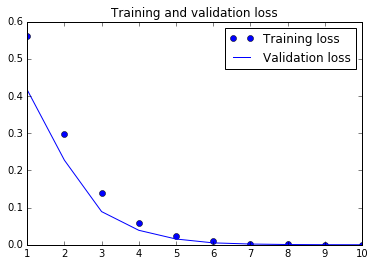

In [464]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss)+1)
pp.plot(epochs, loss, 'bo', label='Training loss')
pp.plot(epochs, val_loss, 'b', label='Validation loss')
pp.title('Training and validation loss')
pp.legend()
pp.show()



## How well does our neural network recreate the rule output?

The model functions for a random input state, but can it iteratively generate a valid spacetime? Below we write some functions to evolve an initial CA space in time and then compare the iterated model with an 80 unit hidden layer.

In [492]:
def model_evolve(model, space, duration=10):
    spacetime = []
    spacetime.append( space )

    for time_step in xrange(duration):
        space = np.around(model.predict(np.array([[space]]))[0][0])
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)

def true_evolve(rule, space, duration=10):
    spacetime = []
    ca_width = space.shape[0]
    spacetime.append( space )

    s0 = list(range(ca_width))
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]


    for time_step in xrange(duration):
        values = 4*spacetime[time_step][sr1] + 2*spacetime[time_step][s0] + 1*spacetime[time_step][sl1]
        space = [] 
        for value in values:
            if (rule >> np.int64(value)) & 0x1:
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)


Now let's look at two examples

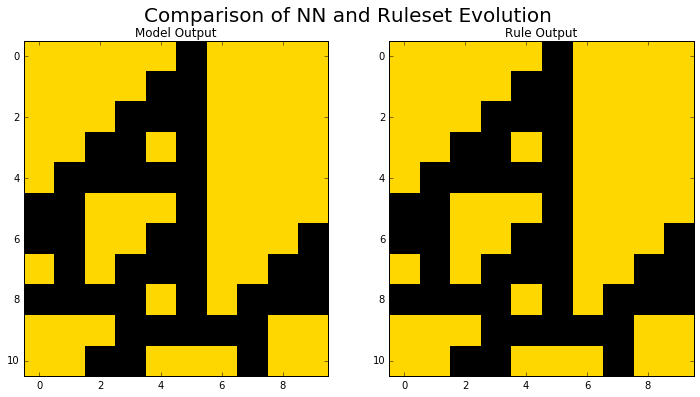

In [475]:
x,y = next(val_gen110)
st1 = model_evolve(model, x[0][0])
st2 = true_evolve(110, x[0][0])

from matplotlib.colors import ListedColormap
fig, (ax1, ax2) = pp.subplots(1,2,figsize=(12, 6))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Comparison of NN and Ruleset Evolution', fontsize=20)

ax1.set_title("Model Output")
ax1.imshow(st1,interpolation='nearest',
                    cmap = cmap)
ax2.set_title("Rule Output")
ax2.imshow(st2,interpolation='nearest',
                    cmap = cmap)
pp.show()

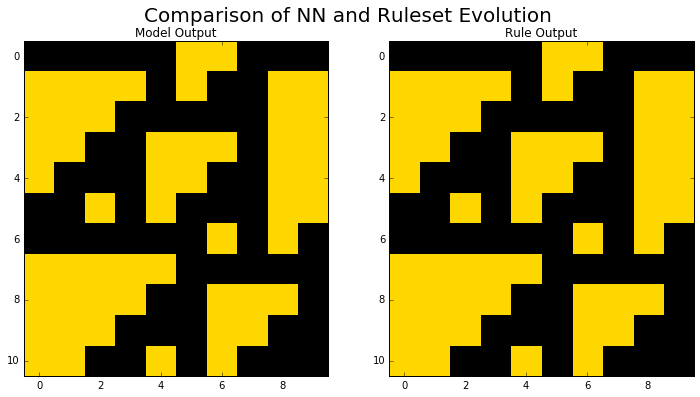

In [476]:
x,y = next(val_gen110)
st1 = model_evolve(model, x[0][0])
st2 = true_evolve(110, x[0][0])

from matplotlib.colors import ListedColormap
fig, (ax1, ax2) = pp.subplots(1,2,figsize=(12, 6))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Comparison of NN and Ruleset Evolution', fontsize=20)

ax1.set_title("Model Output")
ax1.imshow(st1,interpolation='nearest',
                    cmap = cmap)
ax2.set_title("Rule Output")
ax2.imshow(st2,interpolation='nearest',
                    cmap = cmap)
pp.show()

# Scaling up the Model

The number of parameters necessary for modeling a CA is proportional to the square of the input - this suggests that as we make the model larger, we're going to have an increasingly difficult time learning a CA ruleset for a large system.

In [489]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

train_gen110 = generate(110, ca_width=100, batch_size=1, memory=0)
val_gen110 = generate(110, ca_width=100, batch_size=1, memory=0)


model = Sequential() 
model.add(layers.Dense(200, activation='relu', input_shape=(None, 100)))
model.add(layers.Dense(100, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**12,
                             epochs=50,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/50
4096/4096 [==============================] - 11s 3ms/step - loss: 0.6095 - val_loss: 0.5280
Epoch 2/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.5065 - val_loss: 0.4911
Epoch 3/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.4682 - val_loss: 0.4961
Epoch 4/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.4449 - val_loss: 0.4554
Epoch 5/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.4293 - val_loss: 0.4071
Epoch 6/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.4152 - val_loss: 0.4023
Epoch 7/50
4096/4096 [==============================] - 10s 2ms/step - loss: 0.3997 - val_loss: 0.3776
Epoch 8/50
4096/4096 [==============================] - 9s 2ms/step - loss: 0.3665 - val_loss: 0.3571
Epoch 9/50
4096/4096 [==============================] - 10s 2ms/step - loss: 0.3370 - val_loss: 0.3220
Epoch 10/50
4096/4096 [==============================] - 10s 2ms/step - loss: 0

In [490]:
test_predictions(model, val_gen110)

983/1000 correct predictions


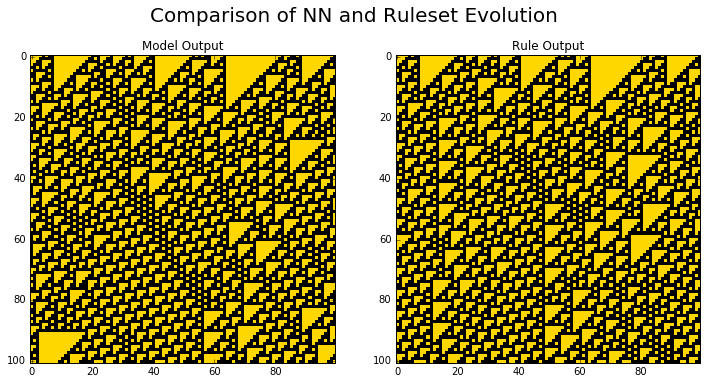

In [493]:
x,y = next(val_gen110)
st1 = model_evolve(model, x[0][0],duration=100)
st2 = true_evolve(110, x[0][0],duration=100)

from matplotlib.colors import ListedColormap
fig, (ax1, ax2) = pp.subplots(1,2,figsize=(12, 6))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Comparison of NN and Ruleset Evolution', fontsize=20)

ax1.set_title("Model Output")
ax1.imshow(st1,interpolation='nearest',
                    cmap = cmap)
ax2.set_title("Rule Output")
ax2.imshow(st2,interpolation='nearest',
                    cmap = cmap)
pp.show()

Even after training this large network for 10 minutes, it doesn't model the CA perfectly. While in this synthetic training environment we can always throw a larger network at a problem and train for longer, real-world problems do not have an infinite amount of data, so it's important to explore models that can be trained properly with less data. The natural choice is to look for a network that builds in some of the details we're trying to train. The convolutional neural network or convnet is this natural choice.

# Convolutional Neural Network
Although the the dense hidden layer is a simple and workable choice for throwing at a general problem, this is a problem in which the neighborhood or local patch of a cell directly determine the future state. Since convnets process input in terms of local patches, they're a natural choice for this problem

In [508]:
def generate(rule, batch_size=10, ca_width=10, memory=0, min_dead=0):
    np.random.randint(ca_width+1)
    while True:
        data = generate_spacetime(rule=rule, 
                               alive = np.random.randint(ca_width+1-min_dead), 
                               ca_width=ca_width,
                               ca_duration = memory+1)
        samples = np.zeros((batch_size, memory+1, ca_width))
        targets = np.zeros((batch_size, ca_width))
        for i in range(batch_size):
            samples[i] = data[:-1]
            targets[i] = data[-1][0]
        yield samples, targets


from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

train_gen110 = generate(110, ca_width=100, batch_size=1, memory=0)
val_gen110 = generate(110, ca_width=100, batch_size=1, memory=0)


model = Sequential()
model.add(layers.Conv1D(200,3, activation='relu', padding='same', input_shape=(None,100)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(100, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**15,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/10
32768/32768 [==============================] - 90s 3ms/step - loss: 0.4568 - val_loss: 0.3705
Epoch 2/10
32768/32768 [==============================] - 88s 3ms/step - loss: 0.2110 - val_loss: 0.0928
Epoch 3/10
32768/32768 [==============================] - 89s 3ms/step - loss: 0.0441 - val_loss: 0.0154
Epoch 4/10
32768/32768 [==============================] - 90s 3ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 5/10
32768/32768 [==============================] - 89s 3ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 6/10
32768/32768 [==============================] - 90s 3ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 7/10
32768/32768 [==============================] - 91s 3ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 8/10
32768/32768 [==============================] - 90s 3ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 9/10
32768/32768 [==============================] - 90s 3ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 10/10
32768/32768 [==============================

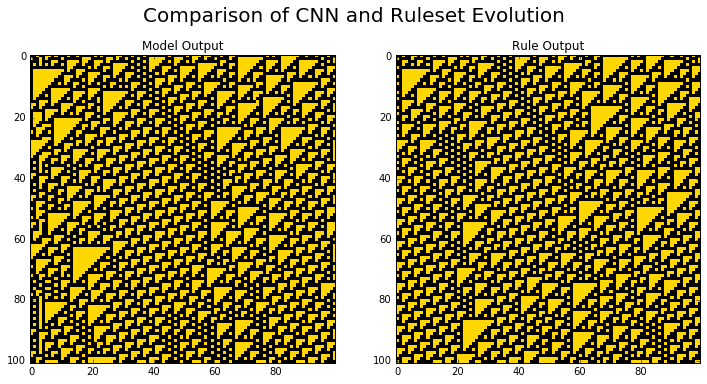

In [510]:
def model_evolve(model, space, duration=10):
    spacetime = []
    spacetime.append( space )

    for time_step in xrange(duration):
        space = np.around(model.predict(np.array([[space]]))[0])
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)

def true_evolve(rule, space, duration=10):
    spacetime = []
    ca_width = space.shape[0]
    spacetime.append( space )

    s0 = list(range(ca_width))
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]


    for time_step in xrange(duration):
        values = 4*spacetime[time_step][sr1] + 2*spacetime[time_step][s0] + 1*spacetime[time_step][sl1]
        space = [] 
        for value in values:
            if (rule >> np.int64(value)) & 0x1:
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)

x,y = next(val_gen110)
st1 = model_evolve(model, x[0][0], duration=100)
st2 = true_evolve(110, x[0][0], duration=100)

from matplotlib.colors import ListedColormap
fig, (ax1, ax2) = pp.subplots(1,2,figsize=(12, 6))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Comparison of CNN and Ruleset Evolution', fontsize=20)

ax1.set_title("Model Output")
ax1.imshow(st1,interpolation='nearest',
                    cmap = cmap)
ax2.set_title("Rule Output")
ax2.imshow(st2,interpolation='nearest',
                    cmap = cmap)
pp.show()

Strangely enough, the CNN fails to significantly improve the results of the basic dense NN.
## Workbook under construction - check back later